In [1]:
# 9-29-2025

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf


import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.layers import Normalization

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

In [3]:
fires = pd.read_csv("fires_with_ndvi.csv")

In [4]:
fires.head()

,OBJECTID,FIRE_YEAR,DISCOVERY_DATE,FIRE_SIZE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,OBJECTID.1,temp_max_F,humidity_pct,precip_in,windspeed_mph,time,ndvi
0,110,2005,2453540.5,10.0,Equipment Use,33.718889,-117.433611,110,73.04,89,0.062992,6.028589,1970-01-01 00:00:00.002453540,5016.0
1,155,2005,2453411.5,3.0,Debris Burning,34.748333,-119.410278,155,58.46,79,0.000000,4.536979,1970-01-01 00:00:00.002453411,3357.0
2,178,2005,2453544.5,4.2,Equipment Use,34.466667,-119.828333,178,77.54,76,0.000000,15.972654,1970-01-01 00:00:00.002453544,4356.0
3,1053,2005,2453559.5,3.0,Miscellaneous,34.479444,-118.768611,1053,82.76,86,0.000000,6.028589,1970-01-01 00:00:00.002453559,3124.0
4,1282,2005,2453582.5,2.0,Lightning,33.110833,-116.847222,1282,87.62,88,0.000000,8.763207,1970-01-01 00:00:00.002453582,4180.0


In [5]:
fires.shape

(2926, 14)

In [6]:
fires = fires.sample(frac=1, random_state = 5)

In [7]:
fires = fires.dropna()

In [8]:
fires_data = fires[["FIRE_SIZE","temp_max_F", "humidity_pct", "precip_in", "windspeed_mph", "ndvi"]].copy()
fires_data

,FIRE_SIZE,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi
2797,2.0,95.54,69,0.0,13.486638,1730.0
1790,3.3,93.20,67,0.0,7.271597,2349.0
186,340.0,82.76,72,0.0,8.949658,4448.0
2504,21.6,75.74,69,0.0,6.712244,2227.0
976,8.0,78.80,16,0.0,15.972654,4496.0
...,...,...,...,...,...,...
2121,47.0,80.78,84,0.0,8.328154,3307.0
1424,7.0,79.88,93,0.0,12.865134,4649.0
1725,78.8,102.74,50,0.0,7.147296,832.0
2254,110.0,93.92,60,0.0,7.022996,4583.0


In [9]:
#fires_data["FIRE_SIZE"] = np.log10(fires_data["FIRE_SIZE"])

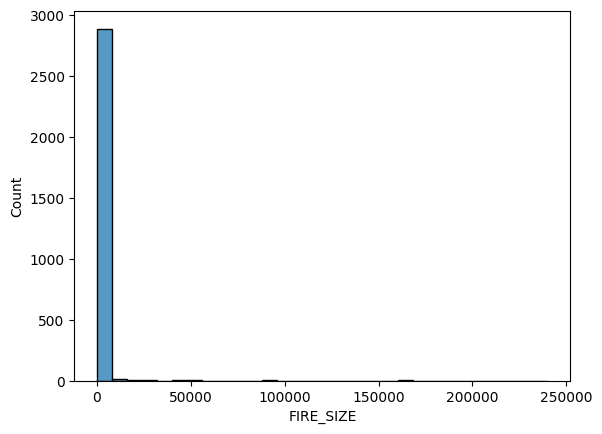

In [10]:
sns.histplot(data=fires_data, x="FIRE_SIZE", bins=30, kde=False)
plt.show()

In [11]:
iqr_cols = ["windspeed_mph"] # not including precip bc it has such a long and small tail, everything's just gonna get clipped
zscore_cols = ["temp_max_F", "humidity_pct"]

In [12]:
for col in iqr_cols:
    Q1 = fires_data[col].quantile(0.25)
    Q3 = fires_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.9 * IQR
    upper = Q3 + 1.9 * IQR
    fires_data[col] = fires_data[col].clip(lower, upper)

In [13]:
k = 3 # 3 std from mean (99.7%)
for col in zscore_cols:
    mean = fires_data[col].mean()
    std = fires_data[col].std()
    lower = mean - k * std
    upper = mean + k * std
    fires_data[col] = fires_data[col].clip(lower, upper)

In [14]:
fires_data

,FIRE_SIZE,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi
2797,2.0,95.54,69.0,0.0,13.486638,1730.0
1790,3.3,93.20,67.0,0.0,7.271597,2349.0
186,340.0,82.76,72.0,0.0,8.949658,4448.0
2504,21.6,75.74,69.0,0.0,6.712244,2227.0
976,8.0,78.80,16.0,0.0,13.971411,4496.0
...,...,...,...,...,...,...
2121,47.0,80.78,84.0,0.0,8.328154,3307.0
1424,7.0,79.88,93.0,0.0,12.865134,4649.0
1725,78.8,102.74,50.0,0.0,7.147296,832.0
2254,110.0,93.92,60.0,0.0,7.022996,4583.0


In [15]:
X = fires_data.drop("FIRE_SIZE", axis=1)
y = fires_data["FIRE_SIZE"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [17]:
power_cols = ["precip_in", "windspeed_mph"]
standard_cols = ["temp_max_F", "humidity_pct", "ndvi"]

In [18]:
std_scaler = StandardScaler()
pwr_scaler = PowerTransformer()

In [19]:
X_train[standard_cols] = std_scaler.fit_transform(X_train[standard_cols])
X_train[power_cols] = pwr_scaler.fit_transform(X_train[power_cols])


X_test[standard_cols] = std_scaler.transform(X_test[standard_cols])
X_test[power_cols] = pwr_scaler.transform(X_test[power_cols])

In [20]:
X_train

,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi
1191,-2.284273,0.685029,-0.310953,-1.164227,-0.594696
1990,-1.181446,-0.754275,-0.310953,0.044621,0.445292
2513,0.456577,-1.114101,-0.310953,0.632677,-0.982280
567,-1.116574,1.199066,-0.310953,0.657105,-0.249203
2338,-0.273235,1.250470,-0.310953,0.324678,0.577702
...,...,...,...,...,...
2579,-1.278754,-0.600064,-0.310953,0.482217,-0.334261
1381,-0.451633,0.736433,-0.310953,-0.166033,0.134874
2639,-1.489589,1.301873,1.333992,0.351452,0.992470
596,1.024209,-0.445853,-0.310953,-2.313137,-1.073477


In [21]:
y_train

1191      2.0
1990      6.0
2513     11.0
567       3.0
2338      3.6
        ...  
2579    632.0
1381     28.0
2639      8.0
596       8.0
2672    211.0
Name: FIRE_SIZE, Length: 2340, dtype: float64

In [38]:
model = Sequential([
    Dense(64),
    LeakyReLU(negative_slope=0.1),
    
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),
    
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),
    
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),
    

    
    Dense(32),
    LeakyReLU(negative_slope=0.1),
    
    Dense(32),
    LeakyReLU(negative_slope=0.1),
    
    Dense(1)
])

In [39]:
model.compile(optimizer="adam", loss="mae", metrics=["mae"])

In [40]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    #validation_split=0.3,
    verbose=1
)

Epoch 1/30


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 610.0978 - mae: 610.0978
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 486.9854 - mae: 486.9854
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 583.6746 - mae: 583.6746
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 668.3433 - mae: 668.3433
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 473.2896 - mae: 473.2896
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 715.1240 - mae: 715.1240
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 665.0571 - mae: 665.0571
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 704.9367 - mae: 704.9367
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 570.7316 - mae: 570.7316
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 557.1841 - mae: 557.1841
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 637.7908 - mae: 637.7908
Epoch 12/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 733.3952 - mae: 733.3952
Epoch 13/30


In [41]:
loss = model.evaluate(X_test, y_test)
print(f"Test loss mae: {loss[1]}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 551.3177 - mae: 551.3177  
Test loss mae: 602.970458984375


In [42]:
loss # gives mae and mse

[602.970458984375, 602.970458984375]

In [43]:
y_pred = model.predict(X_test)
y_pred

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[21.005466 ],
       [ 4.996899 ],
       [ 7.9004903],
       [ 8.429512 ],
       [20.047167 ],
       [28.609985 ],
       [ 4.2983985],
       [ 4.7979484],
       [12.18157  ],
       [ 5.073574 ],
       [ 7.7387266],
       [ 4.9425383],
       [ 3.6077247],
       [ 5.4013124],
       [ 6.1721754],
       [ 4.935413 ],
       [ 4.9221954],
       [ 4.997726 ],
       [ 5.2302136],
       [ 4.186414 ],
       [ 5.2337728],
       [ 6.516667 ],
       [ 4.737448 ],
       [ 7.187584 ],
       [ 4.449933 ],
       [22.252172 ],
       [10.46503  ],
       [ 5.5987635],
       [14.070725 ],
       [ 7.705317 ],
       [ 4.6370344],
       [ 5.004474 ],
       [ 5.3086667],
       [ 5.303653 ],
       [ 4.418978 ],
       [ 5.650932 ],
       [ 5.4263573],
       [ 6.1465244],
       [ 3.656844 ],
       [ 6.30378  ],
       [ 5.5848827],
       [25.305468 ],
       [ 5.6480455],
       [ 5.68784  ],
       [33.767475 ],
       [ 4.9396014],
       [ 5.008517 ],
       [ 4.63

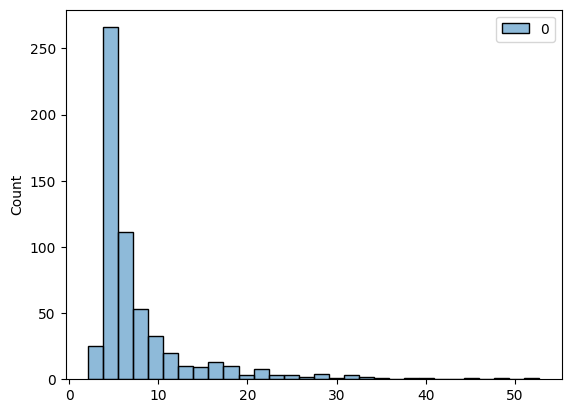

In [44]:
sns.histplot(data=y_pred, bins=30, kde=False)
plt.show()

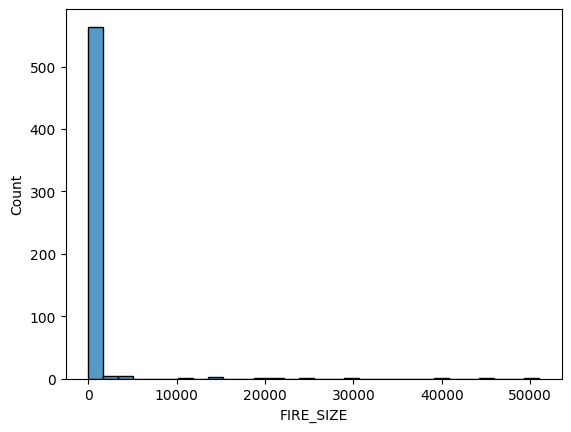

In [45]:
sns.histplot(data=y_test, bins=30, kde=False)
plt.show()

In [ ]:
# changes: 
# added ndvi feature, used z-score scaling
#   had to drop a row from the dataset because the date of that fire was from 1970 and it had no ndvi value
# shuffled the dataset because it seemed that the fires were ordered by date
#   this actually caused the model to do slightly better
# added dropout to the biggest layers in the net
# changed activation to leakyrelu

# after seeing distribution of model predictions, the model is not predicting large fires, it predicted at most a fire of size 50 acres (10^1.7)

# NEED more useful/meaningful features.